In [1]:
!pip install gensim
!pip install razdel
!pip install pymorphy2
!pip install nltk

### Переходим к практике

In [2]:
import pandas as pd

In [3]:
news = pd.read_csv("articles.csv")
users = pd.read_csv("users_articles.csv")

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
#предобработка текстов
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # Скачиваем stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to /Users/tomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
stopword_ru = stopwords.words('russian')

morph = pymorphy2.MorphAnalyzer()

151


In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 29.4 s, sys: 340 ms, total: 29.7 s
Wall time: 30.7 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 40s, sys: 664 ms, total: 3min 41s
Wall time: 3min 41s


А теперь в 3 строчки обучим нашу модель

In [13]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [16]:
from gensim.models import LdaModel

In [46]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary, passes=10)

CPU times: user 7min, sys: 5.17 s, total: 7min 6s
Wall time: 4min 38s


In [47]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [48]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.054642506),
 (4, 0.24120633),
 (5, 0.05392013),
 (7, 0.12409006),
 (8, 0.09405186),
 (14, 0.0323783),
 (22, 0.38122073)]

In [49]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: торговый улица памятник офицер огонь конструкция казахстан
topic_1: убийство миссия ребёнок летний семья следователь фотография
topic_2: британский великобритания nthe лондон летний билет сезон
topic_3: рубль млн тыс сумма деньга размер млрд
topic_4: день гражданин россиянин большой всё изз случай
topic_5: москва дом взрыв московский площадь век смерть
topic_6: врач пациент лечение медицинский состояние больница здоровье
topic_7: матч победа золото чемпионат команда соревнование корейский
topic_8: поверхность космос египет сведение норма искусство лёд
topic_9: ребёнок фонд исследование школа медведев болезнь семья
topic_10: помощь произойти район часть всё около территория
topic_11: военный система операция российский сила советский новый
topic_12: польша кожа польский снежный поляк осадка понижение
topic_13: земля планета пенсия проверка звезда университет конкурс
topic_14: ракета китай снижение доллар китайский превысить железный
topic_15: мозг метод препарат су дания экскур

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [50]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [51]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.021312,0.0,0.000000,0.0,0.000000,0.036042,0.000000,0.000000,0.000000,...,0.0,0.092232,0.000000,0.213082,0.135425,0.023460,0.377461,0.094622,0.0,0.0
1,4896,0.233887,0.0,0.000000,0.0,0.000000,0.330321,0.000000,0.156356,0.000000,...,0.0,0.000000,0.000000,0.167647,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,4897,0.000000,0.0,0.054639,0.0,0.241205,0.053919,0.000000,0.124089,0.094051,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.381228,0.0,0.0
3,4898,0.000000,0.0,0.060493,0.0,0.104021,0.000000,0.020817,0.073472,0.000000,...,0.0,0.000000,0.013495,0.000000,0.000000,0.000000,0.101484,0.362285,0.0,0.0
4,4899,0.035161,0.0,0.098231,0.0,0.000000,0.039818,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.029496,0.445211,0.079698,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [53]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [55]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [59]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.013739,0.027437,0.025295,0.024511,0.063057,0.046365,0.008739,0.009396,0.006301,...,0.0,0.056449,0.008893,0.037703,0.042005,0.036246,0.166703,0.022857,0.030569,0.146916
1,u108690,0.000000,0.007392,0.000000,0.024107,0.077651,0.031593,0.003232,0.000000,0.000000,...,0.0,0.107431,0.000000,0.072610,0.034014,0.017685,0.216876,0.101354,0.069804,0.070835
2,u108339,0.010714,0.028206,0.016213,0.029584,0.098367,0.048509,0.011086,0.000000,0.004510,...,0.0,0.035326,0.012703,0.114478,0.024185,0.028885,0.210657,0.003276,0.033272,0.044019


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [60]:
target = pd.read_csv("users_churn.csv")

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [61]:
X = pd.merge(user_embeddings, target, 'left')

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.013739,0.027437,0.025295,0.024511,0.063057,0.046365,0.008739,0.009396,0.006301,...,0.056449,0.008893,0.037703,0.042005,0.036246,0.166703,0.022857,0.030569,0.146916,0
1,u108690,0.000000,0.007392,0.000000,0.024107,0.077651,0.031593,0.003232,0.000000,0.000000,...,0.107431,0.000000,0.072610,0.034014,0.017685,0.216876,0.101354,0.069804,0.070835,1
2,u108339,0.010714,0.028206,0.016213,0.029584,0.098367,0.048509,0.011086,0.000000,0.004510,...,0.035326,0.012703,0.114478,0.024185,0.028885,0.210657,0.003276,0.033272,0.044019,1


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [63]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [64]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [77]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08510498, 0.0259896 , 0.50540552, 0.30070953, 0.08413234,
       0.09781854, 0.18800314, 0.03832874, 0.08801976, 0.13094318])

In [66]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [68]:
import itertools

In [78]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                       fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.323563, F-Score=0.790, Precision=0.861, Recall=0.731


In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1726   29]
 [  67  178]]


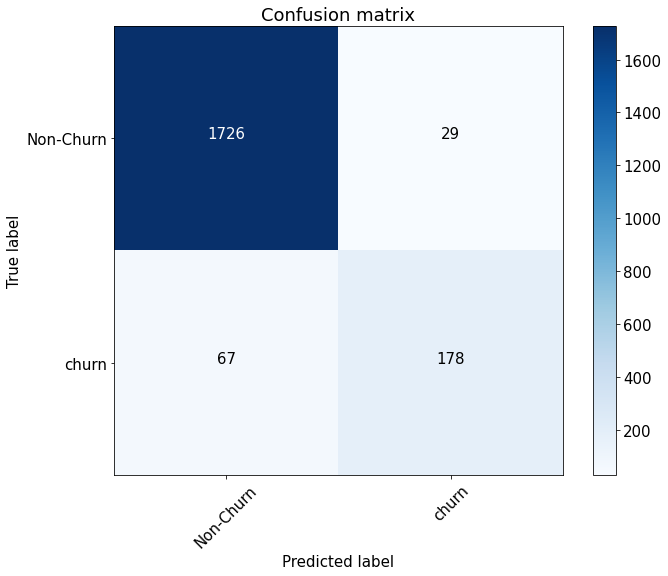

In [80]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [81]:
roc_auc_score(y_test, preds)

0.9689354032211175

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Практическая часть:
    
    (с TFIDF не разобрался)

In [163]:
# модифицирую функцию get_user_embedding, добавив параметр metric

def get_user_embedding(user_articles_list, metric='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if metric == 'median':
        user_vector = np.median(user_vector, 0)
    elif metric == 'max':
        user_vector = np.max(user_vector, 0)
    else:
        user_vector = np.mean(user_vector, 0)
    return user_vector

In [157]:
# Создал функцию, для оценки качества 

def evaluate_model(metric):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, metric=metric), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    
    X = pd.merge(user_embeddings, target, 'left')
    
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    preds = logreg.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    
    rocauc = roc_auc_score(y_test, preds)

    ix = np.argmax(fscore)
    
    return metric, round(thresholds[ix],2), round(fscore[ix],2), round(precision[ix],2), round(recall[ix],2), round(rocauc,2)

In [159]:
results = pd.DataFrame(columns=['metric', 'best threshold', 'f-score', 'precision', 'recall', 'roc_auc'])

In [160]:
for el in ['mean', 'median', 'max']:
    metric, threshold, fscore, precision, recall, roc_auc = evaluate_model(el)
    to_append = {'metric': metric, 'best threshold': threshold, 'f-score': fscore, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc}
    results = results.append(to_append, ignore_index=True)

In [161]:
results

,metric,best threshold,f-score,precision,recall,roc_auc
0,mean,0.32,0.79,0.86,0.73,0.97
1,median,0.26,0.76,0.71,0.81,0.97
2,max,0.32,0.75,0.72,0.79,0.96


mean показала лучшие результаты в f_score, как и ожидалось, потому что max не объективна, ведь читатель может один раз прочитать статью, но это не значит что он однозначно увлекается этой темой, но из-за max, мы уже обозначим читателя как заинтересованного. Например тема "животные": пользователь прочитал всего 1 статью из 10, связанных с животными, его вектор будет выглядеть так: [0.79, 0, 0, 0, 0, 0, 0, 0, 0, 0] но из-за np.max в финальную оценку пойдет именно 0.79, что не отображает истину. Примерно та же ситуация с median, потому что median просто возьмет 0, что тоже не является правдой, ведь пользователю хотя бы чуть-чуть, но было интересно посмотреть на статью с животными. Таким образом, mean подходит больше всего в данном случае, что подтверждается метрикой fscore.